# CIL on Google Colab

In this notebook, we show how to install [CIL](https://github.com/TomographicImaging/CIL) and all its dependencies on Google Colab with free access to GPU (16Gb).


Note: Sometimes the session will crash while downloading and updating packages. You should use the  "run all" button when it happens and it should (fingers crossed) sort itself out.

### First downgrade the numpy version as CIL
CIL is not yet compatible with numpy 2.0. You may need to press "run all" a number of times to get this working.

In [1]:
import importlib.metadata

desired_version = "1.26.4"

installed_version = importlib.metadata.version("numpy")
if installed_version == desired_version:
    print(f"NumPy {desired_version} is already installed.")
else:
    print(f"Installing NumPy {desired_version} (current: {installed_version})...")
    !pip install numpy=={desired_version} --prefer-binary
    import os
    os._exit(00)

NumPy 1.26.4 is already installed.


## Install conda on colab

Your session may crash here, this is normal, just run the next cell or run all again.

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


### Install CIL with Google Colab





 We can install CIL with  `Astra` and `Tigre` using the conda distribution.

Note - this may crash, just click "run all" again.


In [3]:
!conda install -c conda-forge -c https://software.repos.intel.com/python/conda -c ccpi cil=24.3.0 ipp=2021.12 astra-toolbox=*=cuda* tigre ccpi-regulariser tomophantom ipykernel ipywidgets scikit-image --quiet


Channels:
 - conda-forge
 - https://software.repos.intel.com/python/conda
 - ccpi
Platform: linux-64
Solving environment: ...working... done

# All requested packages already installed.



where:

- `astra-toolbox=*=py*` enables CIL support for [ASTRA toolbox](http://www.astra-toolbox.com) CPU projector (2D Parallel beam only) (GPLv3 license)
- `astra-toolbox=*=cuda*` (requires an NVIDIA GPU) enables CIL support for [ASTRA toolbox](http://www.astra-toolbox.com) GPU projectors (GPLv3 license)
- `tigre` (requires an NVIDIA GPU) enables support for [TIGRE](https://github.com/CERN/TIGRE) toolbox projectors (BSD license)
- `ccpi-regulariser` is the [CCPi Regularisation Toolkit](https://github.com/TomographicImaging/CCPi-Regularisation-Toolkit)
- `tomophantom` can generate phantoms to use as test data [Tomophantom](https://github.com/dkazanc/TomoPhantom)
- `ipykernel`  provides the IPython kernel for Jupyter (allowing jupyter notebooks to be run)
- `ipywidgets` enables visulisation tools within jupyter noteboooks


### Limited Angle Tomography Reconstruction

In this notebook, we use a three-dimensional parallel-beam X-ray CT real dataset from Beamline I13-2, Diamond Light Source, Harwell, UK.

The sample consisted of a 0.5 mm aluminium cylinder with a piece of steel wire embedded in a small drilled hole. A droplet of salt water was placed on top, causing corrosion to form hydrogen bubbles. The dataset, which was part of a fast time-lapse experiment, consists of 91 projections over 180, originally acquired as size 2560-by-2160 pixels, but provided in [here](https://github.com/DiamondLightSource/Savu/blob/master/test_data/data/24737_fd.nxs) downsampled to 160-by-135 pixels.

We reconstruct this dataset using analytic and iterative reconstruction methods with a limited number of projections:

* the Filtered Back Projection (FBP) algorithm,

* Total variation (TV) regularisation under a non-negativity constraint

    <a id='tv_reg'></a>
    \begin{equation}
    \underset{u}{\operatorname{argmin}} \frac{1}{2} \| A u - d\|^{2}_{2} + \alpha\,\mathrm{TV}(u) + \mathbb{I}_{\{u\geq0\}}(u)
    \tag{1}
    \end{equation}

    where,

    * d is a noisy sinogram and
    * $A$ is the Projection operator. (TIGRE or Astra)

### Import libraries

In [4]:
from cil.framework import  AcquisitionGeometry
from cil.processors import TransmissionAbsorptionConverter, Slicer, CentreOfRotationCorrector
from cil.optimisation.functions import L2NormSquared
from cil.optimisation.algorithms import PDHG
from cil.utilities.display import show2D, show_geometry
from cil.utilities import dataexample
from cil.plugins.ccpi_regularisation.functions import FGP_TV

import matplotlib.pyplot as plt

import numpy as np

### Select tomography backend: ASTRA or TIGRE


In [5]:
from cil.plugins.astra import ProjectionOperator, FBP # Astra Backend
#from cil.plugins.tigre import ProjectionOperator, FBP # TIGRE backend

In [6]:
import cil.version
print(cil.version.version)

24.3.0


### Load Dataset

In [7]:
data_raw = dataexample.SYNCHROTRON_PARALLEL_BEAM_DATA.get(data_dir="/usr/local/share/cil")

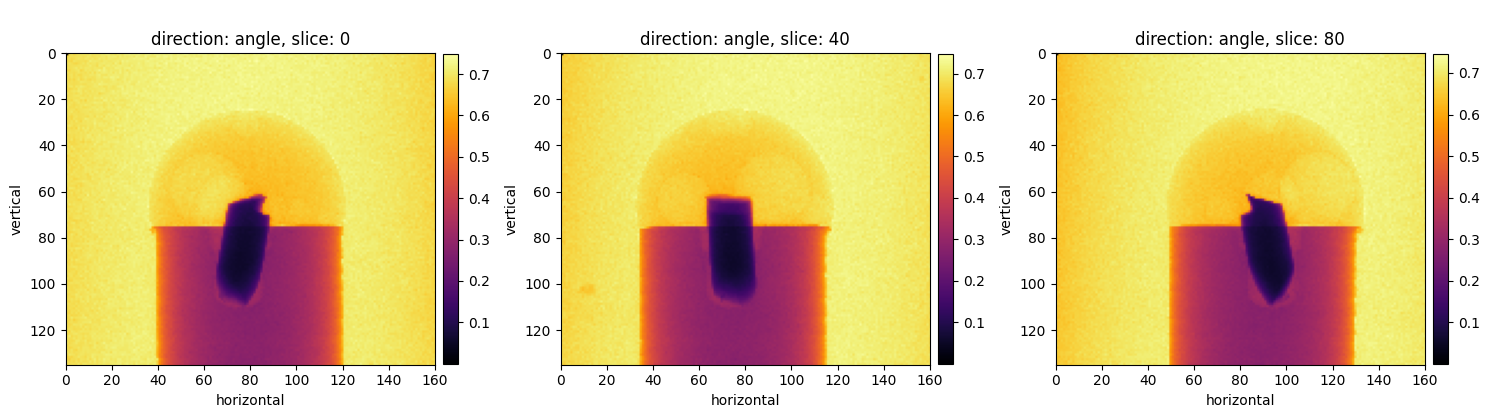

In [8]:
show2D(data_raw, slice_list=[('angle',0), ('angle', 40), ('angle',80)], \
        cmap="inferno", num_cols=3, origin='upper')

### Preprocess Sinogram data

In the code above, we preprocess our acquired data:

- Convert to Absorption using Lambert-Beer law
- Correct centre of rotation artifacts
- Limit the number of angles

In [9]:
background = data_raw.get_slice(vertical=20).mean()
data_raw /= background

# Lambert-Beer law
data_abs = TransmissionAbsorptionConverter()(data_raw)
data_crop = Slicer(roi={'vertical': (1, None)})(data_abs)

# Reorder the shape of sinogram only if astra backend is used
data_crop.reorder(order='astra')

# Correct centre of rotation artifacts
data_centred = CentreOfRotationCorrector.xcorrelation()(data_crop)

# Reduce number of projections
data_centred = Slicer(roi={'angle': (0, 90, 6), 'horizontal': (20,140,1)})(data_centred)

# Get acquisition geometry
ag = data_centred.geometry

# Get image geometry
ig = ag.get_ImageGeometry()



### Show Acquisition Geometry

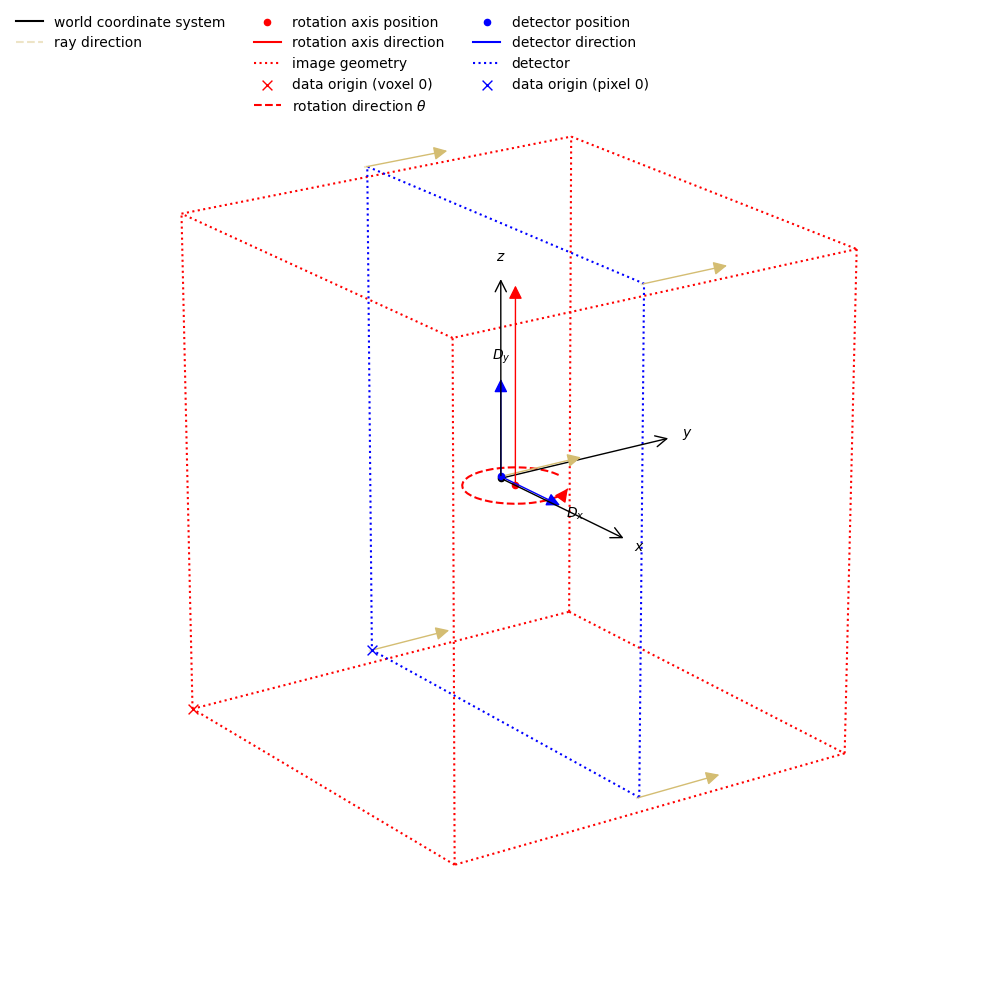

In [10]:
show_geometry(ag)

### Run 3D FBP reconstruction

**TIGRE backend: If you use TIGRE, please reorder the data using** `data_centred.reorder("tigre")`.

In [11]:
## data_centred.reorder("tigre")
fbp_recon = FBP(ig, ag, device='gpu')(data_centred)

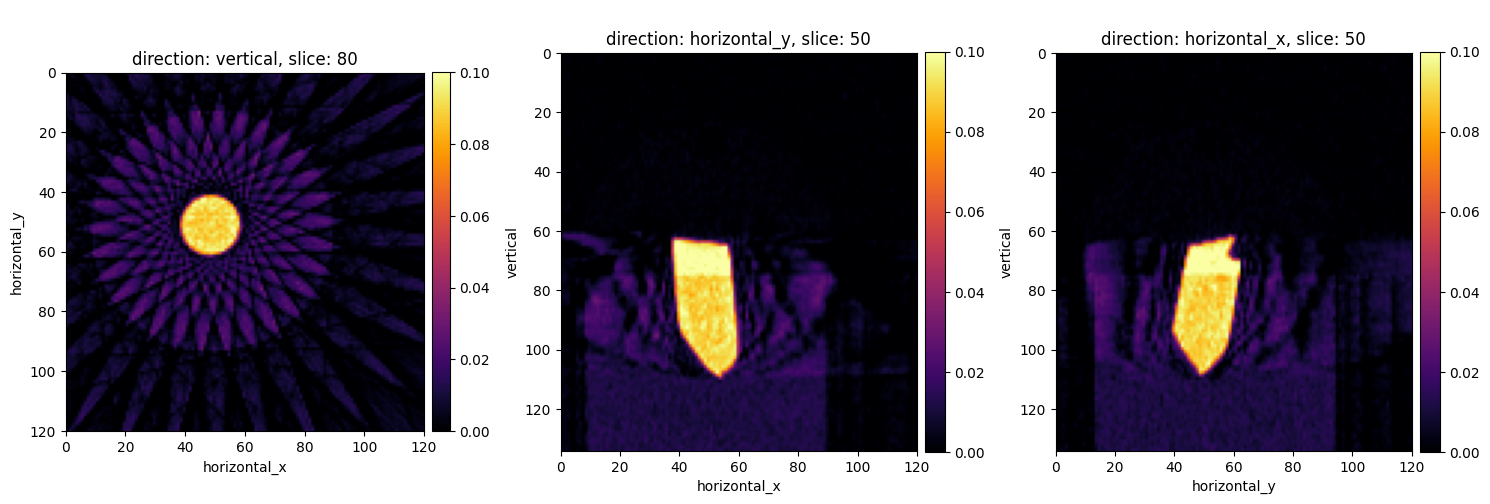

In [12]:
# visualise reconstruction results
show2D(fbp_recon, slice_list=[('vertical',80),
                              ('horizontal_y',50),
                              ('horizontal_x',50)], \
        cmap="inferno", num_cols=3, size=(15,15),
       fix_range = (0,0.1),
       origin='upper-left')


### Total variation reconstruction

For the total variation (TV) regularisation under a non-negativity constraint, we use
the [Primal-Dual Hybrid Gradient (PDHG)]([ChambollePock](https://link.springer.com/article/10.1007/s10851-010-0251-1)). The PDHG algorithm solves the following problem:

$$\underset{x\in \mathbb{X} }{\operatorname{argmin}} f(Kx) + g(x).$$

In our case, we have $K=A$, i.e., our projection operator
```A = ProjectionOperator(ig, ag, device="gpu")```

**Note: cpu option is not available for the TIGRE backend**

The fidelity term is formed using $f(z) = \frac{1}{2}\|z - d\|^{2}$

`F = 0.5*L2NormSquared(b=data_centred)
`

Finally, the function $g$ is the proximal operator of the total variation with non-negativity constraint, i.e.,

$$\underset{v}{\operatorname{argmin}} \frac{1}{2}\|v-x\|^{2} + \alpha\mathrm{TV}(v) + \mathbb{I}_{\{v>0\}}(v)$$

The above problem is solve using the [FISTA](https://ieeexplore.ieee.org/document/4959678) algorithm, i.e., Fast Gradient Projection algorithm.

`G = alpha * FGP_TV(device = "gpu")`

**Note: In CIL, we provide wrappers from the [CCPi-Regularisation Toolkit](https://github.com/vais-ral/CCPi-Regularisation-Toolkit) in order to compute efficiently (CPU/GPU) different proximal operators.**


In [13]:
# Projection Operator
A = ProjectionOperator(ig, ag, device="gpu")

# Fidelity term
F = 0.5*L2NormSquared(b=data_centred)

# TV regularization
alpha = 0.2
G = alpha * FGP_TV(nonnegativity=True, device = "gpu")

# setup and run PDHG algorithm
pdhg = PDHG(initial=ig.allocate(), f=F, g=G, operator=A,
            update_objective_interval=10, check_convergence=False)
pdhg.run(100)

  0%|          | 0/100 [00:00<?, ?it/s]

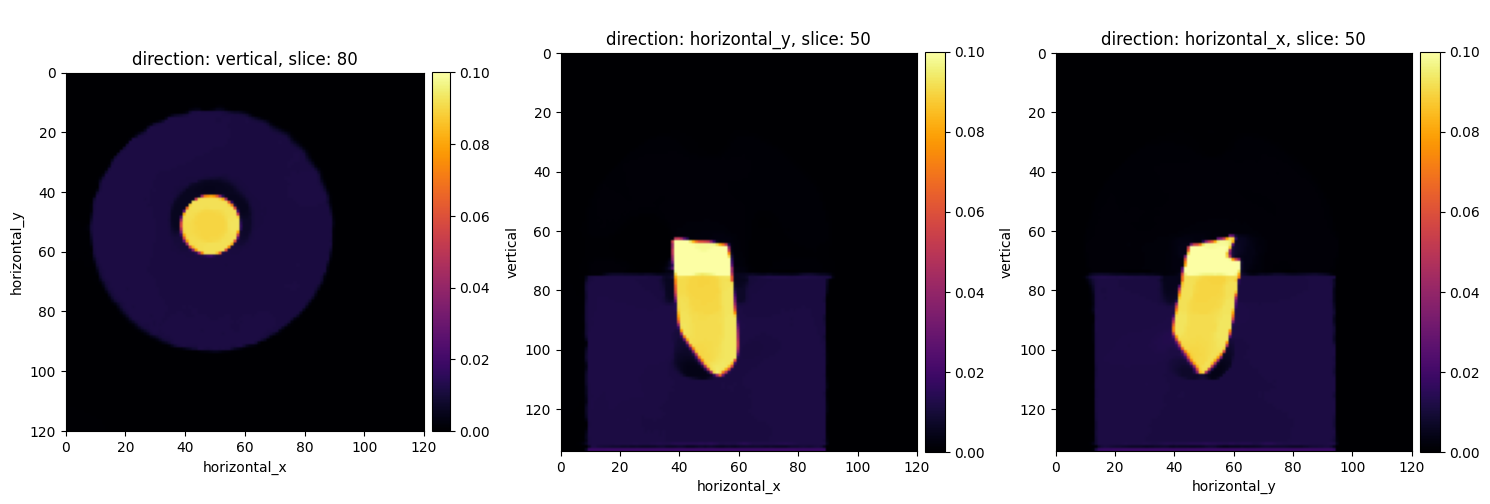

In [14]:
show2D(pdhg.solution, slice_list=[('vertical',80),
                              ('horizontal_y',50),
                              ('horizontal_x',50)], \
        cmap="inferno", num_cols=3,
        fix_range=(0,0.1), origin='upper')

### Other tomography demos on Google Colab

To try more demos on Google Colab, please visit our [CIL-Demos](https://github.com/TomographicImaging/CIL-Demos) repository and load one of our notebooks to the Google Colab platform and repeat the installation steps above.

